In [42]:
import pandas as pd 

In [43]:
df_occupancy = pd.read_csv("prep_data/hotelid0_daily_occupancy.csv")
df_dataset = pd.read_csv("prep_data/prepped0.csv")

In [44]:
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28927 entries, 0 to 28926
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           28927 non-null  int64  
 1   index                28927 non-null  int64  
 2   hotel_id             28927 non-null  int64  
 3   datum_dolaska        28927 non-null  object 
 4   datum_odjave         28927 non-null  object 
 5   kanal_prodaje_id     28927 non-null  int64  
 6   tip_sobe_id          28927 non-null  int64  
 7   cijena_nocenja       28927 non-null  float64
 8   rezervacija_id       28927 non-null  int64  
 9   gost_id              28927 non-null  int64  
 10  zemlja_gosta_mapped  28927 non-null  int64  
 11  broj_gostiju         28927 non-null  float64
dtypes: float64(2), int64(8), object(2)
memory usage: 2.6+ MB


In [45]:
df_occupancy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793 entries, 0 to 792
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   datum_dolaska    793 non-null    object 
 1   total_occupancy  793 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.5+ KB


In [46]:
df_occupancy['datum_dolaska'] = pd.to_datetime(df_occupancy['datum_dolaska'])
df_dataset['datum_dolaska'] = pd.to_datetime(df_dataset['datum_dolaska'])

In [47]:
df = pd.merge(df_dataset, df_occupancy, on='datum_dolaska', how='left')

In [48]:
df.head()

,Unnamed: 0,index,hotel_id,datum_dolaska,datum_odjave,kanal_prodaje_id,tip_sobe_id,cijena_nocenja,rezervacija_id,gost_id,zemlja_gosta_mapped,broj_gostiju,total_occupancy
0,0,0,0,2015-07-01,2015-07-01,0,0,100.000000,1313223,1077152,0,2.0,72.0
1,1,1,0,2015-07-01,2015-07-01,0,0,100.000000,1313224,1017906,0,2.0,72.0
2,2,2,0,2015-07-01,2015-07-02,0,1,64.991345,1313225,1039896,1,1.0,72.0
3,3,3,0,2015-07-01,2015-07-02,1,1,74.368897,1313226,1008245,1,1.0,72.0
4,4,4,0,2015-07-01,2015-07-03,2,1,130.973278,1313227,1093703,1,2.0,72.0


In [49]:
df = df.drop(columns = ["Unnamed: 0", "broj_gostiju","index","hotel_id"])
df['datum_odjave'] = pd.to_datetime(df['datum_odjave'])

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28927 entries, 0 to 28926
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datum_dolaska        28927 non-null  datetime64[ns]
 1   datum_odjave         28927 non-null  datetime64[ns]
 2   kanal_prodaje_id     28927 non-null  int64         
 3   tip_sobe_id          28927 non-null  int64         
 4   cijena_nocenja       28927 non-null  float64       
 5   rezervacija_id       28927 non-null  int64         
 6   gost_id              28927 non-null  int64         
 7   zemlja_gosta_mapped  28927 non-null  int64         
 8   total_occupancy      28927 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(5)
memory usage: 2.2 MB


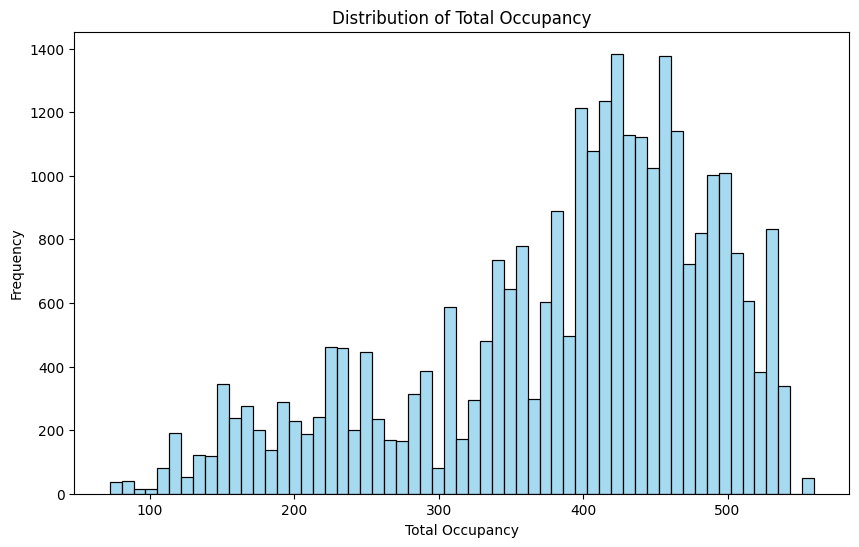

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df['total_occupancy'], color='skyblue')
plt.title('Distribution of Total Occupancy')
plt.xlabel('Total Occupancy')
plt.ylabel('Frequency')
plt.show()

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

X = df[['kanal_prodaje_id', 'tip_sobe_id', 'cijena_nocenja', 'gost_id', 'zemlja_gosta_mapped']]
y = df['total_occupancy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

# results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
# print(results_df)

Mean Absolute Error: 77.08272290597581


In [52]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [65]:
split_percentage = 0.8

train_data, test_data = train_test_split(df, test_size=(1 - split_percentage), shuffle=False)

X_train_gb = train_data[['kanal_prodaje_id', 'tip_sobe_id', 'cijena_nocenja']]
y_train_gb = train_data['total_occupancy']
X_test_gb = test_data[['kanal_prodaje_id', 'tip_sobe_id', 'cijena_nocenja']]
y_test_gb = test_data['total_occupancy']

X_train_arima = train_data.set_index('datum_dolaska')['total_occupancy']
X_test_arima = test_data.set_index('datum_dolaska')['total_occupancy']

gb_model = GradientBoostingRegressor(random_state=27)
gb_model.fit(X_train_gb, y_train_gb)
y_pred_gb = gb_model.predict(X_test_gb)

arima_model = sm.tsa.ARIMA(X_train_arima, order=(1, 1, 1))
arima_result = arima_model.fit()
y_pred_arima = arima_result.forecast(steps=len(X_test_arima))


results_df_gb = pd.DataFrame({'Actual': y_test_gb, 'Predicted (Gradient Boosting)': y_pred_gb})
#results_df_arima = pd.DataFrame({'Actual': X_test_arima.reset_index(drop=True), 'Predicted (ARIMA)': y_pred_arima})

# print(results_df_gb)
# print(results_df_arima)

c:\Users\vojislav\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\vojislav\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\vojislav\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\vojislav\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but 

In [58]:
import numpy as np 
mae_gb = mean_absolute_error(results_df_gb['Actual'], results_df_gb['Predicted (Gradient Boosting)'])
mse_gb = mean_squared_error(results_df_gb['Actual'], results_df_gb['Predicted (Gradient Boosting)'])
rmse_gb = np.sqrt(mse_gb)

print(f'Mean Absolute Error (GB): {mae_gb}')
print(f'Mean Squared Error (GB): {mse_gb}')
print(f'Root Mean Squared Error (GB): {rmse_gb}')

Mean Absolute Error (GB): 56.21086032597928
Mean Squared Error (GB): 5070.014720553004
Root Mean Squared Error (GB): 71.20403584455732


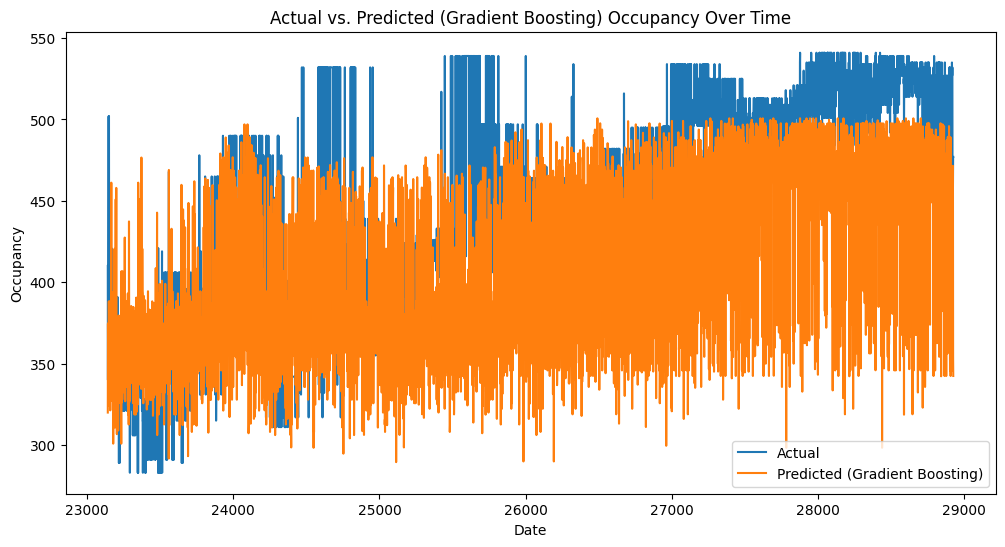

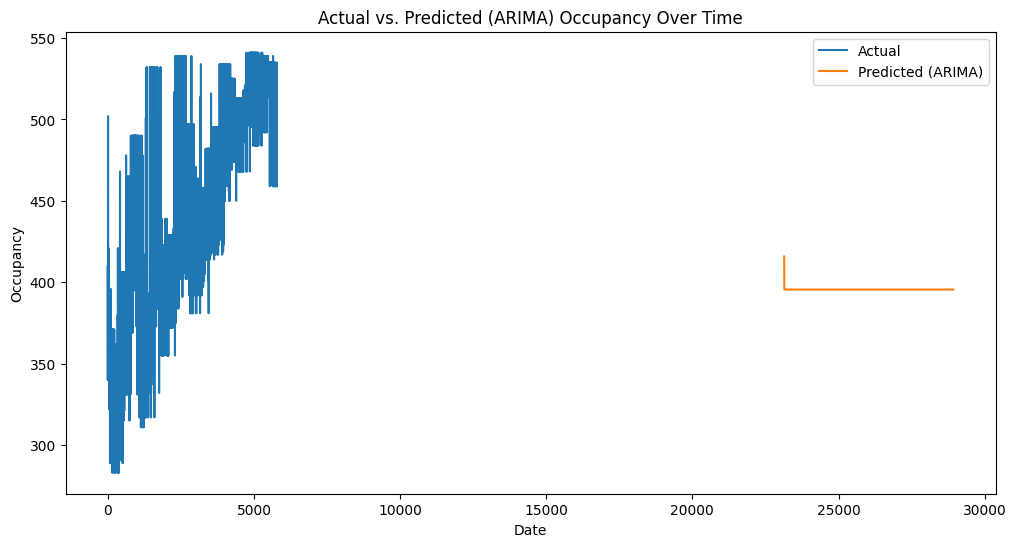

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(results_df_gb.index, results_df_gb['Actual'], label='Actual')
plt.plot(results_df_gb.index, results_df_gb['Predicted (Gradient Boosting)'], label='Predicted (Gradient Boosting)')
plt.title('Actual vs. Predicted (Gradient Boosting) Occupancy Over Time')
plt.xlabel('Date')
plt.ylabel('Occupancy')
plt.legend()
plt.show()

# plt.figure(figsize=(12, 6))
# plt.plot(results_df_arima.index, results_df_arima['Actual'], label='Actual')
# plt.plot(results_df_arima.index, results_df_arima['Predicted (ARIMA)'], label='Predicted (ARIMA)')
# plt.title('Actual vs. Predicted (ARIMA) Occupancy Over Time')
# plt.xlabel('Date')
# plt.ylabel('Occupancy')
# plt.legend()
# plt.show()

In [59]:
from sklearn.ensemble import RandomForestRegressor


X_train_rf = train_data[['kanal_prodaje_id', 'tip_sobe_id', 'cijena_nocenja']]
y_train_rf = train_data['total_occupancy']
X_test_rf = test_data[['kanal_prodaje_id', 'tip_sobe_id', 'cijena_nocenja']]
y_test_rf = test_data['total_occupancy']


rf_model = RandomForestRegressor(random_state=27)
rf_model.fit(X_train_rf, y_train_rf)
y_pred_rf = rf_model.predict(X_test_rf)

mae_rf = mean_absolute_error(y_test_rf, y_pred_rf)
mse_rf = mean_squared_error(y_test_rf, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print(f'Mean Absolute Error (RF): {mae_rf}')
print(f'Mean Squared Error (RF): {mse_rf}')
print(f'Root Mean Squared Error (RF): {rmse_rf}')

Mean Absolute Error (RF): 65.63295779633906
Mean Squared Error (RF): 7546.687001192077
Root Mean Squared Error (RF): 86.87166972720208


In [60]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

X_train_svr = train_data[['kanal_prodaje_id', 'tip_sobe_id', 'cijena_nocenja']]
y_train_svr = train_data['total_occupancy']
X_test_svr = test_data[['kanal_prodaje_id', 'tip_sobe_id', 'cijena_nocenja']]
y_test_svr = test_data['total_occupancy']

#SVR model se pravi putem pajplajna
svr_model = make_pipeline(StandardScaler(), SVR())
svr_model.fit(X_train_svr, y_train_svr)
y_pred_svr = svr_model.predict(X_test_svr)

mae_svr = mean_absolute_error(y_test_svr, y_pred_svr)
mse_svr = mean_squared_error(y_test_svr, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)

print(f'Mean Absolute Error (SVR): {mae_svr}')
print(f'Mean Squared Error (SVR): {mse_svr}')
print(f'Root Mean Squared Error (SVR): {rmse_svr}')

Mean Absolute Error (SVR): 47.47156890803437
Mean Squared Error (SVR): 3547.466060470774
Root Mean Squared Error (SVR): 59.56060829500295


SVR je za sad najbolji model ali mu treba najduze da se izvrsi

Mean Absolute Error (ElasticNet): 77.08686705832196
Mean Squared Error (ElasticNet): 9546.320784438743
Root Mean Squared Error (ElasticNet): 97.70527511060364


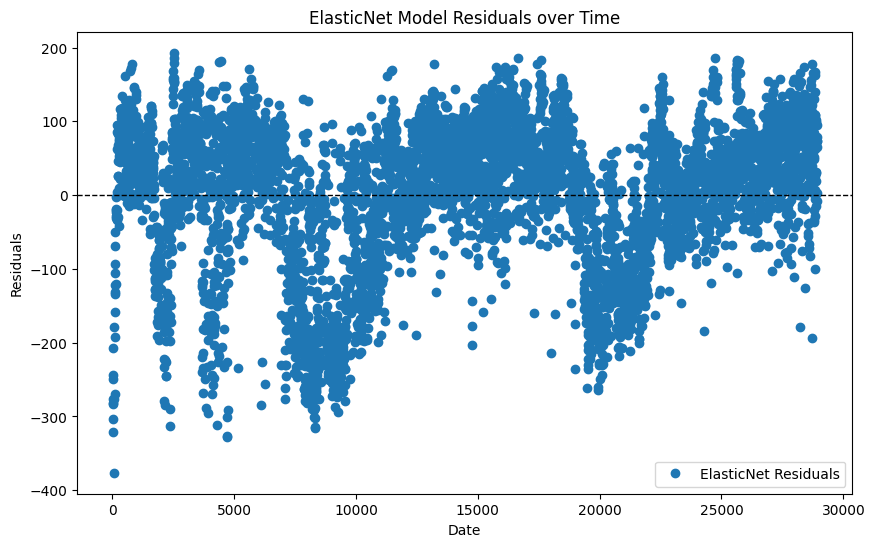

In [76]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt


elasticnet_model = ElasticNet(alpha=0.1, l1_ratio=1)  # You can adjust alpha and l1_ratio as needed

elasticnet_model.fit(X_train, y_train)

y_pred_elasticnet = elasticnet_model.predict(X_test)

mae_elasticnet = mean_absolute_error(y_test, y_pred_elasticnet)
mse_elasticnet = mean_squared_error(y_test, y_pred_elasticnet)
rmse_elasticnet = np.sqrt(mse_elasticnet)
# Print the errors
print(f'Mean Absolute Error (ElasticNet): {mae_elasticnet}')
print(f'Mean Squared Error (ElasticNet): {mse_elasticnet}')
print(f'Root Mean Squared Error (ElasticNet): {rmse_elasticnet}')

residuals_elasticnet = y_test - y_pred_elasticnet

plt.figure(figsize=(10, 6))
plt.plot(X_test.index, residuals_elasticnet, label='ElasticNet Residuals', marker='o', linestyle='None')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('ElasticNet Model Residuals over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()


In [81]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming you have the actual and predicted values for each model
actual_values = y_test  # Replace with your actual values
predicted_values_gb = gb_model.predict(X_test_gb)
predicted_values_rf = rf_model.predict(X_test_rf)
predicted_values_svr = svr_model.predict(X_test_svr)
predicted_values_elasticnet = elasticnet_model.predict(X_test)
predicted_values_linear = linear_model.predict(X_test)

# Create a DataFrame to store the results
results_df = pd.DataFrame(index=['MAE', 'MSE', 'R-squared'])

# Calculate metrics for each model
metrics_gb = [mean_absolute_error(y_test_gb, predicted_values_gb),
              mean_squared_error(y_test_gb, predicted_values_gb),
              r2_score(y_test_gb, predicted_values_gb)]
results_df['Gradient Boosting'] = metrics_gb

metrics_rf = [mean_absolute_error(y_test_rf, predicted_values_rf),
              mean_squared_error(y_test_rf, predicted_values_rf),
              r2_score(y_test_rf, predicted_values_rf)]
results_df['Random Forest'] = metrics_rf

metrics_svr = [mean_absolute_error(y_test_svr, predicted_values_svr),
               mean_squared_error(y_test_svr, predicted_values_svr),
               r2_score(y_test_svr, predicted_values_svr)]
results_df['SVR'] = metrics_svr

metrics_elasticnet = [mean_absolute_error(actual_values, predicted_values_elasticnet),
                      mean_squared_error(actual_values, predicted_values_elasticnet),
                      r2_score(actual_values, predicted_values_elasticnet)]
results_df['ElasticNet'] = metrics_elasticnet

metrics_linear = [mean_absolute_error(actual_values, predicted_values_linear),
                  mean_squared_error(actual_values, predicted_values_linear),
                  r2_score(actual_values, predicted_values_linear)]
results_df['Linear Regression'] = metrics_linear

# Display the results
print(results_df)

           Gradient Boosting  Random Forest          SVM   ElasticNet  \
MAE                56.211366      65.632958    47.471569    77.086867   
MSE              5069.994371    7546.687001  3547.466060  9546.320784   
R-squared          -0.308144      -0.947172     0.084694     0.158325   

           Linear Regression  
MAE                77.082723  
MSE              9545.972395  
R-squared           0.158356  
